In [19]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [20]:
import os
import re
import time
import shutil
import requests
import numpy as np
import pandas as pd
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
from typing import List, Dict, Union

In [21]:
# shutil.rmtree('text')
# shutil.rmtree('processed')

Crawl zuddl knowledge base and text preprocessing

In [23]:
# Regex pattern to match a URL
HTTP_URL_PATTERN = r'^http[s]*://.+'

# Define root domain to crawl
domain = "help.zuddl.com"
full_url = "https://help.zuddl.com/support/home"

Page = Dict[str, Union[str, Dict[str, str]]]
PAGES: List[Page] = []

# Create a class to parse the HTML and get the hyperlinks
class HyperlinkParser(HTMLParser):
    def __init__(self) -> None:
        super().__init__()
        # Create a list to store the hyperlinks
        self.hyperlinks = []

    # Override the HTMLParser's handle_starttag method to get the hyperlinks
    def handle_starttag(self, tag, attrs) -> None:
        attrs = dict(attrs)

        # If the tag is an anchor tag and it has an href attribute, add the href attribute to the list of hyperlinks
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])

# Function to get the hyperlinks from a URL
def get_hyperlinks(url: str) -> List[str]:
    
    # Try to open the URL and read the HTML
    try:
        # Open the URL and read the HTML
        with urllib.request.urlopen(url) as response:

            # If the response is not HTML, return an empty list
            if not response.info().get('Content-Type').startswith("text/html"):
                return []
            
            # Decode the HTML
            html = response.read().decode('utf-8')
    except Exception as e:
        print(e)
        return []

    # Create the HTML Parser and then Parse the HTML to get hyperlinks
    parser = HyperlinkParser()
    parser.feed(html)

    return parser.hyperlinks

# Function to get the hyperlinks from a URL that are within the same domain
def get_domain_hyperlinks(local_domain: str, url: str) -> List[str]:
    clean_links = []
    for link in set(get_hyperlinks(url)):
        clean_link = None

        # If the link is a URL, check if it is within the same domain
        if re.search(HTTP_URL_PATTERN, link):
            # Parse the URL and check if the domain is the same
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link

        # If the link is not a URL, check if it is a relative link
        else:
            if link.startswith("/"):
                link = link[1:]
            elif link.startswith("#") or link.startswith("mailto:"):
                continue
            clean_link = "https://" + local_domain + "/" + link

        if clean_link is not None:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)

    # Return the list of hyperlinks that are within the same domain
    return list(set(clean_links))

In [24]:
def truncate_string(text: str) -> str:
    end_index = text.find("Was this article helpful?")
    start_index = text.find("Sorry! nothing found for") + 24

    if start_index != -1 or end_index != -1:
      return text[start_index:end_index]
    if start_index != -1:
      return text[:end_index]
    if end_index != -1:
      return text[start_index:]
    
    return text

def remove_newlines(text: str) -> str:
    text = text.replace('\n', ' ')
    text = text.replace('\\n', ' ')
    text = text.replace('  ', ' ')
    text = text.replace('  ', ' ')
    return text

def process_text(text: str) -> str:
  text = remove_newlines(text)
  text = truncate_string(text)
  return text.strip()

In [25]:
def crawl(url: str) -> None:
    # Parse the URL and get the domain
    local_domain = urlparse(url).netloc

    # Create a queue to store the URLs to crawl
    queue = deque([url])

    # Create a set to store the URLs that have already been seen (no duplicates)
    seen = set([url])

    # Create a directory to store the text files
    if not os.path.exists("text/"):
            os.mkdir("text/")

    if not os.path.exists("text/"+local_domain+"/"):
            os.mkdir("text/" + local_domain + "/")

    # Create a directory to store the csv files
    if not os.path.exists("processed"):
            os.mkdir("processed")

    # While the queue is not empty, continue crawling
    while queue:

        # Get the next URL from the queue
        url = queue.pop()

        # Save text from the url to a <url>.txt file
        with open('text/'+local_domain+'/'+url[8:].replace("/", "_") + ".txt", "w") as f:

            # Sleep to avoid rate limiting
            time.sleep(1)
            
            # Get the text from the URL using BeautifulSoup
            soup = BeautifulSoup(requests.get(url).text, "html.parser")

            # Get the text but remove the tags
            text = soup.get_text()

            processed_text = process_text(text)

            if soup.title:
                title = str(soup.title.string).strip()
            else:
                title = ""
            
            print(f"{title} - {url}")

            # If the crawler gets to a page that requires JavaScript, it will stop the crawl
            if ("You need to enable JavaScript to run this app." in text):
                print("Unable to parse page " + url + " due to JavaScript being required")
            
            # Otherwise, write the text to the file in the text directory
            f.write(processed_text)
            
            PAGES.append({
              'content': processed_text + '\n\n',
              'metadata': {
                'title': title,
                'url': url
              }
            })

        # Get the hyperlinks from the URL and add them to the queue
        for link in get_domain_hyperlinks(local_domain, url):
            if link not in seen:
                queue.append(link)
                seen.add(link)

In [26]:
crawl(full_url)

Support : zuddl - https://help.zuddl.com/support/home
Marketo Integration - Export Registrant Data : zuddl - https://help.zuddl.com/support/solutions/articles/84000375234-marketo-integration-export-registrant-data
Slack+Salesforce Integration : zuddl - https://help.zuddl.com/support/solutions/articles/84000374271-slack-salesforce-integration
Salesforce Integration - Import Registrant Data : zuddl - https://help.zuddl.com/support/solutions/articles/84000380220-salesforce-integration-import-registrant-data
HubSpot Integration - Import Registrant Data : zuddl - https://help.zuddl.com/support/solutions/articles/84000378754-hubspot-integration-import-registrant-data
Auto sync your Zuddl session recordings to Wistia projects. : zuddl - https://help.zuddl.com/support/solutions/articles/84000381685-how-to-integrate-wistia-with-zuddl
How to Integrate Eloqua with Zuddl : zuddl - https://help.zuddl.com/support/solutions/articles/84000378829-how-to-integrate-eloqua-with-zuddl
How to Integrate Zapi

Sample Metadata output

In [27]:
print(PAGES[200]['metadata'])

{'title': 'Widgets - Overview : zuddl', 'url': 'https://help.zuddl.com/support/solutions/articles/84000374548-widgets-overview'}


Using tiktoken to estimate the total number of tokens

<Axes: >

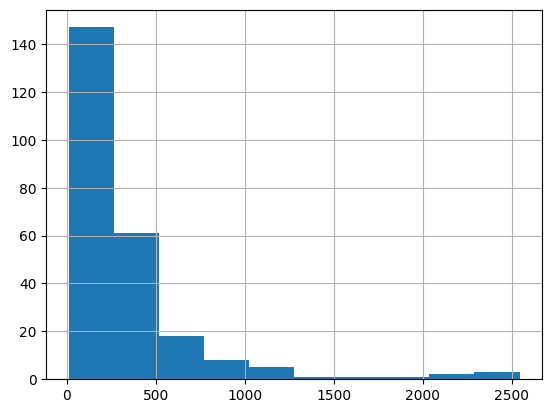

In [28]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

data_modified = [
    {
        'title': d['metadata']['title'],
        'url': d['metadata']['url'],
        'content': d['content']
    }
    for d in PAGES
]

# Create DataFrame
df_tokens = pd.DataFrame(data_modified)

# Tokenize the text and save the number of tokens to a new column
df_tokens['n_tokens'] = df_tokens.content.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df_tokens.n_tokens.hist()

In [29]:
df_tokens

,title,url,content,n_tokens
0,Support : zuddl,https://help.zuddl.com/support/home,Browse articles Explore How-To's and learn bes...,117
1,Marketo Integration - Export Registrant Data :...,https://help.zuddl.com/support/solutions/artic...,Marketo Integration - Export Registrant Data ...,2508
2,Slack+Salesforce Integration : zuddl,https://help.zuddl.com/support/solutions/artic...,"Slack+Salesforce Integration Modified on Mon,...",1243
3,Salesforce Integration - Import Registrant Dat...,https://help.zuddl.com/support/solutions/artic...,Salesforce Integration - Import Registrant Dat...,991
4,HubSpot Integration - Import Registrant Data :...,https://help.zuddl.com/support/solutions/artic...,HubSpot Integration - Import Registrant Data ...,1534
...,...,...,...,...
242,Webinar Guide : zuddl,https://help.zuddl.com/support/solutions/84000...,Webinar Guide (11) Create a New Webinar (1)...,153
243,Events (New) - Guide : zuddl,https://help.zuddl.com/support/solutions/84000...,Events (New) - Guide (18) Learn everything abo...,274
244,Sign into : zuddl,https://help.zuddl.com/support/search/tickets,Skip to main content zuddl Home Knowle...,135
245,Studio Guide : zuddl,https://help.zuddl.com/support/solutions/84000...,Studio Guide (11) Getting Started (6) Setti...,167


Splitting the text into smaller chunks for efficiency

In [30]:
from langchain.text_splitter import TokenTextSplitter

chunk_type = Dict[str, Union[str, int, List]]

def chunk_data() -> List[chunk_type]:
    text_splitter = TokenTextSplitter(encoding_name="cl100k_base", chunk_size=500, chunk_overlap=100)

    chunks = []

    for page in PAGES:
        splits = text_splitter.split_text(page['content'])

        for split in splits:
          chunks.append({
              "article_title": page['metadata']['title'],
              "article_url": page['metadata']['url'],
              "content": split,
              "content_length": len(split),
              "content_tokens": len(tokenizer.encode(split)),
              "embedding": []
          })
        print(f"Splitted {page['metadata']['url']} into {len(splits)} chunks.")

    print(f'Total chunks created: {len(chunks)}.\n')
    return chunks

In [31]:
chunks = chunk_data()

Splitted https://help.zuddl.com/support/home into 1 chunks.
Splitted https://help.zuddl.com/support/solutions/articles/84000375234-marketo-integration-export-registrant-data into 7 chunks.
Splitted https://help.zuddl.com/support/solutions/articles/84000374271-slack-salesforce-integration into 4 chunks.
Splitted https://help.zuddl.com/support/solutions/articles/84000380220-salesforce-integration-import-registrant-data into 3 chunks.
Splitted https://help.zuddl.com/support/solutions/articles/84000378754-hubspot-integration-import-registrant-data into 4 chunks.
Splitted https://help.zuddl.com/support/solutions/articles/84000381685-how-to-integrate-wistia-with-zuddl into 2 chunks.
Splitted https://help.zuddl.com/support/solutions/articles/84000378829-how-to-integrate-eloqua-with-zuddl into 4 chunks.
Splitted https://help.zuddl.com/support/solutions/articles/84000379114-how-to-integrate-zapier-with-zuddl into 3 chunks.
Splitted https://help.zuddl.com/support/solutions/articles/84000371192-m

Sample chunked object

In [33]:
import json
print(json.dumps(chunks[8], sort_keys=True, indent=4))

{
    "article_title": "Slack+Salesforce Integration : zuddl",
    "article_url": "https://help.zuddl.com/support/solutions/articles/84000374271-slack-salesforce-integration",
    "content": "Slack+Salesforce Integration  Modified on Mon, 30 Jan 2023 at 12:05 AM    The Slack+Salesforce integration allows Zuddl to send notifications to the Salesforce account/ contact/ lead owner (in addition to a specific channel) in your Slack workspace when attendees perform certain actions on Zuddl. Currently, Zuddl notifies you of the following attendee actions:User registrationRegistrant check-in to the event (first time joining)This integration sends notifications in a selected Slack channel and also to the following recipients in the order of availability in Salesforce:Account ownerContact ownerLead ownerBefore sending the notification, the integration checks for the registrant\u2019s email address in Salesforce in the following manner: if a Contact exists with the same email and is associated wi

Distribution for number of tokens in the chunks dataframe

<Axes: >

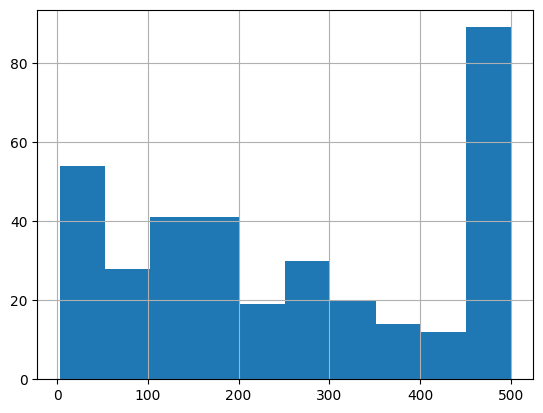

In [34]:
df_chunked = pd.DataFrame(chunks)

# Visualize the distribution of the number of tokens per row using a histogram
df_chunked.content_tokens.hist()

In [35]:
df_chunked

,article_title,article_url,content,content_length,content_tokens,embedding
0,Support : zuddl,https://help.zuddl.com/support/home,Browse articles Explore How-To's and learn bes...,589,117,[]
1,Marketo Integration - Export Registrant Data :...,https://help.zuddl.com/support/solutions/artic...,Marketo Integration - Export Registrant Data ...,2379,500,[]
2,Marketo Integration - Export Registrant Data :...,https://help.zuddl.com/support/solutions/artic...,create a new user with APi only Role permissi...,2333,500,[]
3,Marketo Integration - Export Registrant Data :...,https://help.zuddl.com/support/solutions/artic...,"Marketo account on Zuddl.Now, select your acc...",2282,500,[]
4,Marketo Integration - Export Registrant Data :...,https://help.zuddl.com/support/solutions/artic...,"Zuddl activities, you can either create one m...",2337,500,[]
...,...,...,...,...,...,...
343,Zuddl Salesforce Integration : zuddl,https://help.zuddl.com/support/solutions/artic...,Salesforce.Create a CampaignTo create a campa...,2363,500,[]
344,Zuddl Salesforce Integration : zuddl,https://help.zuddl.com/support/solutions/artic...,"her to the respective campaign.For event B, i...",2318,500,[]
345,Zuddl Salesforce Integration : zuddl,https://help.zuddl.com/support/solutions/artic...,in an event.“Zuddl Discussion Room Duration”:...,2338,500,[]
346,Zuddl Salesforce Integration : zuddl,https://help.zuddl.com/support/solutions/artic...,.Test campaign member statusAssuming that a ce...,2276,500,[]


Saving the dataframe as CSV and JSON

In [36]:
df_chunked.to_csv('processed/chunks.csv', index=True)
df_chunked.to_json('processed/chunks.json', orient='records', index=True)

Total number of tokens generated

In [37]:
df_chunked['content_tokens'].sum()

90088

Generating embeddings using OpenAI embeddings API

In [42]:
import openai

openai.api_key = os.environ.get('OPENAI_API_KEY')

def create_embedding(text: str):
    response = openai.Embedding.create(
        input = text,
        model = 'text-embedding-ada-002'
    )

    embedding = response['data'][0]['embedding']
    
    with open('processed/embeds.txt', 'a') as f1:
        f1.write(str(embedding) + '\n\n')

    with open('processed/response.txt', 'a') as f0:
        f0.write(text + '\n' + str(response) + '\n\n\n')

    return embedding

In [43]:
for i, row in df_chunked.iterrows():
  print(f"Processing row {i + 1} of {len(df_chunked)}")
  
  embedding = create_embedding(row["content"])

  if embedding:
    df_chunked.at[i, "embedding"] = embedding

Processing row 1 of 348
Processing row 2 of 348
Processing row 3 of 348
Processing row 4 of 348
Processing row 5 of 348
Processing row 6 of 348
Processing row 7 of 348
Processing row 8 of 348
Processing row 9 of 348
Processing row 10 of 348
Processing row 11 of 348
Processing row 12 of 348
Processing row 13 of 348
Processing row 14 of 348
Processing row 15 of 348
Processing row 16 of 348
Processing row 17 of 348
Processing row 18 of 348
Processing row 19 of 348
Processing row 20 of 348
Processing row 21 of 348
Processing row 22 of 348
Processing row 23 of 348
Processing row 24 of 348
Processing row 25 of 348
Processing row 26 of 348
Processing row 27 of 348
Processing row 28 of 348
Processing row 29 of 348
Processing row 30 of 348
Processing row 31 of 348
Processing row 32 of 348
Processing row 33 of 348
Processing row 34 of 348
Processing row 35 of 348
Processing row 36 of 348
Processing row 37 of 348
Processing row 38 of 348
Processing row 39 of 348
Processing row 40 of 348
Processin

In [44]:
df_chunked

,article_title,article_url,content,content_length,content_tokens,embedding
0,Support : zuddl,https://help.zuddl.com/support/home,Browse articles Explore How-To's and learn bes...,589,117,"[0.010322058573365211, -0.00882257055491209, 0..."
1,Marketo Integration - Export Registrant Data :...,https://help.zuddl.com/support/solutions/artic...,Marketo Integration - Export Registrant Data ...,2379,500,"[-0.015161781571805477, -0.022629722952842712,..."
2,Marketo Integration - Export Registrant Data :...,https://help.zuddl.com/support/solutions/artic...,create a new user with APi only Role permissi...,2333,500,"[-0.018355760723352432, -0.013434087857604027,..."
3,Marketo Integration - Export Registrant Data :...,https://help.zuddl.com/support/solutions/artic...,"Marketo account on Zuddl.Now, select your acc...",2282,500,"[-0.024368315935134888, -0.022753629833459854,..."
4,Marketo Integration - Export Registrant Data :...,https://help.zuddl.com/support/solutions/artic...,"Zuddl activities, you can either create one m...",2337,500,"[-0.0121785718947649, -0.021134383976459503, -..."
...,...,...,...,...,...,...
343,Zuddl Salesforce Integration : zuddl,https://help.zuddl.com/support/solutions/artic...,Salesforce.Create a CampaignTo create a campa...,2363,500,"[-0.012549150735139847, -0.026721376925706863,..."
344,Zuddl Salesforce Integration : zuddl,https://help.zuddl.com/support/solutions/artic...,"her to the respective campaign.For event B, i...",2318,500,"[-0.014646720141172409, 0.002296808874234557, ..."
345,Zuddl Salesforce Integration : zuddl,https://help.zuddl.com/support/solutions/artic...,in an event.“Zuddl Discussion Room Duration”:...,2338,500,"[-0.017282968387007713, -0.005131722427904606,..."
346,Zuddl Salesforce Integration : zuddl,https://help.zuddl.com/support/solutions/artic...,.Test campaign member statusAssuming that a ce...,2276,500,"[-0.023075032979249954, -0.014361383393406868,..."


Saving the dataframe as CSV and JSON

In [45]:
df_chunked.to_csv('processed/chunks_with_embeds.csv', index=True)
df_chunked.to_json('processed/chunks_with_embeds.json', orient='records', index=True)

Saving the dataframe to postgres database

In [46]:
from supabase import create_client, Client

url: str = os.environ.get("SUPABASE_URL")
key: str = os.environ.get("SUPABASE_KEY")
supabase: Client = create_client(url, key)

In [52]:
def insert_articles(row) -> None:
		data, count = supabase.table('articles_duplicate').insert({
			"article_title": row["article_title"],
			"article_url": row["article_url"],
			"content_length": row["content_length"],
			"content_tokens": row["content_tokens"],
			"content": row["content"],
			"embedding": row["embedding"],
			}).execute()

In [51]:
for i, row in df_chunked.iterrows():
	print(f"Inserting row {i + 1} of {len(df_chunked)}")
	insert_articles(row)

Inserting row 1 of 348
Inserting row 2 of 348
Inserting row 3 of 348
Inserting row 4 of 348
Inserting row 5 of 348
Inserting row 6 of 348
Inserting row 7 of 348
Inserting row 8 of 348
Inserting row 9 of 348
Inserting row 10 of 348
Inserting row 11 of 348
Inserting row 12 of 348
Inserting row 13 of 348
Inserting row 14 of 348
Inserting row 15 of 348
Inserting row 16 of 348
Inserting row 17 of 348
Inserting row 18 of 348
Inserting row 19 of 348
Inserting row 20 of 348
Inserting row 21 of 348
Inserting row 22 of 348
Inserting row 23 of 348
Inserting row 24 of 348
Inserting row 25 of 348
Inserting row 26 of 348
Inserting row 27 of 348
Inserting row 28 of 348
Inserting row 29 of 348
Inserting row 30 of 348
Inserting row 31 of 348
Inserting row 32 of 348
Inserting row 33 of 348
Inserting row 34 of 348
Inserting row 35 of 348
Inserting row 36 of 348
Inserting row 37 of 348
Inserting row 38 of 348
Inserting row 39 of 348
Inserting row 40 of 348
Inserting row 41 of 348
Inserting row 42 of 348
I